# BERT's Attention and Dependency Syntax

This notebook contains code for comparing BERT's attention to dependency syntax annotations (see Sections 4.2 and 5 of [What Does BERT Look At? An Analysis of BERT's Attention](https://arxiv.org/abs/1906.04341))

In [1]:
import collections
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import json 

In [2]:
plt.rcParams.update({'font.size': 14})

In [3]:
def get_relns_NL(dataset):
    relns = set()
    for example in dataset:
        for reln in example["relns"]:
            relns.add(reln)
    relns = list(relns)
    relns.sort()
    relns.remove("root")
    return relns


# average topk scores for each relationship and categories (word level)
def get_avg_NL(scores, relns, max_k=20):
    reln_avg = [None]*(max_k+1)

    for k in range(1, (max_k+1)):
        sum, count = 0, 0
        for reln in relns:
            flatten_idx = np.argmax(scores[reln][:,:,k])
            num_head = scores[reln].shape[1]
            # print(num_head)
            row = int(flatten_idx/num_head)
            col = flatten_idx % num_head
            sum += scores[reln][row][col][k]
            count += 1
        reln_avg[k] = sum/count
    return reln_avg

def print_attn_table_NL(k, relns, scores):
    print("relationship\t\t  accuracy\tlayer\thead")
    sum, count = 0, 0
    table = ""
    for reln in relns:
        flatten_idx = np.argmax(scores[reln][:,:,k])
        num_head = scores[reln].shape[1]
        row = int(flatten_idx/num_head)
        col = flatten_idx % num_head
        table += reln.ljust(30) + str(round(scores[reln][row][col][k],3)).ljust(5) + "\t" + str(row) + "\t" + str(col) + '\n'
        sum += scores[reln][row][col][k]
        count += 1
    print(table)
    print("average of",count,"relations:", sum/count)



def get_scores_topk(reln_scores_topk, max_k=20):
    scores_topk = [0]*(max_k+1)
    for k in range(1, max_k+1):
        sum, count = 0, 0
        for key, value in reln_scores_topk.items():
            sum += value[k][0]
            count += 1
        scores_topk[k] = sum/count
    last = 0
    for i in range(0, max_k+1):
        if scores_topk[i] == 0:
            scores_topk[i] = last
        else:
            last = scores_topk[i]
    return scores_topk

def get_relns_by_frequency(dataset):
    reln_counts = collections.Counter()
    for example in dataset:
        for reln in example["relns"]:
            reln_counts[reln] += 1
    relns = reln_counts.most_common()
    return relns

def print_attn_baseline_table_NL(k, relns, scores, names):
    sums, count = [0]*len(scores), 0
    table = "relation\t" + '\t'.join(names)
    for reln in relns:
        table += '\n' + reln.ljust(10)
        count += 1
        for i, score in enumerate(scores):
            if names[i] != "offset":
                flatten_idx = np.argmax(score[reln][:,:,k])
                num_head = score[reln].shape[1]
                row = int(flatten_idx/num_head)
                col = flatten_idx % num_head
                table += '\t'+str(round(score[reln][row][col][k],3)).ljust(5) +" (" + str(row)+"-"+str(col) +")"
                sums[i] += score[reln][row][col][k]
            else:
                table += "\t" + str(round(score[reln][k][0],3)).ljust(5) +" ("+ str(score[reln][k][1])[1:-1] +")"
                sums[i] += score[reln][k][0]
                
    print(table, "\n")
    print(count, "relations")
    for i, score in enumerate(scores):
        print("average score for", names[i], ":", sums[i]/count)

# English Results

['acomp', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'auxpass', 'cc', 'ccomp', 'conj', 'cop', 'csubj', 'csubjpass', 'dep', 'det', 'discourse', 'dobj', 'expl', 'iobj', 'mark', 'mwe', 'neg', 'nn', 'npadvmod', 'nsubj', 'nsubjpass', 'num', 'number', 'parataxis', 'pcomp', 'pobj', 'poss', 'possessive', 'preconj', 'predet', 'prep', 'prt', 'punct', 'quantmod', 'rcmod', 'tmod', 'vmod', 'xcomp']
bert base 62.4 81.6 95.8 99.2
bert large 64.6 83.2 96.3 99.3
roberta base 62.7 84.3 96.9 99.4
roberta large 59.9 81.2 96.3 99.3
codebert 59.3 79.7 95.2 99.1
offset 47.1 72.7 91.0 96.6


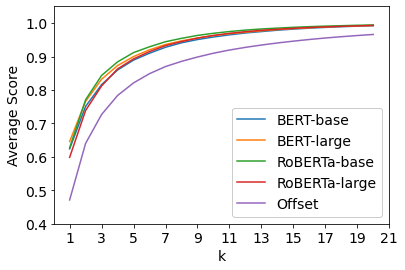

In [6]:
with open("data/depparse_english/dev.json", "r") as f:
    dataset = json.load(f)
relns = get_relns_NL(dataset)
print(relns)

with open("data/depparse_english/bert_base_topk_scores_cased.pkl", "rb") as f:
    scores = pickle.load(f)
reln_avg = get_avg_NL(scores, relns, max_k=20)

with open("data/depparse_english/bert_large_topk_scores_cased.pkl", "rb") as f:
    bert_large_scores = pickle.load(f)
bert_large_reln_avg = get_avg_NL(bert_large_scores, relns, max_k=20)

with open("data/depparse_english/roberta_base_topk_scores.pkl", "rb") as f:
    roberta_base_scores = pickle.load(f)
roberta_base_reln_avg = get_avg_NL(roberta_base_scores, relns, max_k=20)

with open("data/depparse_english/roberta_large_topk_scores.pkl", "rb") as f:
    roberta_large_scores = pickle.load(f)
roberta_large_reln_avg = get_avg_NL(roberta_large_scores, relns, max_k=20)

with open("data/depparse_english/roberta_base_topk_scores_offset.pkl", "rb") as f:
    reln_scores_topk_offset = pickle.load(f)
scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)

with open("data/depparse_english/NL_codebert_topk_scores.pkl", "rb") as f:
    codebert_scores = pickle.load(f)
codebert_reln_avg = get_avg_NL(codebert_scores, relns, max_k=20)

print("bert base", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
print("bert large", round(bert_large_reln_avg[1]*100, 1), round(bert_large_reln_avg[3]*100, 1), 
      round(bert_large_reln_avg[10]*100, 1), round(bert_large_reln_avg[20]*100, 1))
print("roberta base", round(roberta_base_reln_avg[1]*100, 1), round(roberta_base_reln_avg[3]*100, 1), 
      round(roberta_base_reln_avg[10]*100, 1), round(roberta_base_reln_avg[20]*100, 1))
print("roberta large", round(roberta_large_reln_avg[1]*100, 1), round(roberta_large_reln_avg[3]*100, 1), 
      round(roberta_large_reln_avg[10]*100, 1), round(roberta_large_reln_avg[20]*100, 1))
print("codebert", round(codebert_reln_avg[1]*100, 1), round(codebert_reln_avg[3]*100, 1), 
      round(codebert_reln_avg[10]*100, 1), round(codebert_reln_avg[20]*100, 1))
print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                   round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))

plt.rcParams["figure.figsize"] = (8,5)
x = [k for k in range(1, 21)]
plt.plot(x, reln_avg[1:21], label = "BERT-base")  # attention score
plt.plot(x, bert_large_reln_avg[1:21], label = "BERT-large")  # attention score
plt.plot(x, roberta_base_reln_avg[1:21], label = "RoBERTa-base")  # attention score
plt.plot(x, roberta_large_reln_avg[1:21], label = "RoBERTa-large")  # attention score
# plt.plot(x, codebert_reln_avg[1:21], label = "CodeBERT")  # attention score
plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")

plt.xticks(range(1,22, 2))
plt.xlabel("k")
plt.ylabel("Average Score")
# plt.title("NL English")
plt.legend(framealpha=1, frameon=True, loc='lower right');
plt.ylim([0.4, 1.05])
fig = plt.gcf()
fig.set_size_inches(6., 4)
fig.savefig("../../data/figures/English.pdf", bbox_inches='tight')
plt.show()

# keywords only: 52 keywords
# offset only: 512 offsets
# keywords+offset: max of two


In [7]:
relns = [r for r,c in get_relns_by_frequency(dataset)]
relns.remove("root")
print_attn_baseline_table_NL(1, relns, [scores, bert_large_scores, roberta_base_scores, roberta_large_scores, reln_scores_topk_offset], 
                             ["BERT Base", "BERT Large", "RoBERTa base", "RoBERTa large", "offset"])

relation	BERT Base	BERT Large	RoBERTa base	RoBERTa large	offset
punct     	0.253 (6-4)	0.316 (14-10)	0.241 (5-3)	0.18  (3-14)	0.176 (-1)
prep      	0.712 (6-2)	0.734 (15-0)	0.675 (10-2)	0.652 (5-1)	0.624 (-1)
pobj      	0.681 (8-0)	0.657 (15-8)	0.611 (9-0)	0.75  (8-6)	0.354 (-2)
nn        	0.75  (5-4)	0.728 (11-12)	0.777 (8-0)	0.745 (1-9)	0.745 (1)
det       	0.938 (6-4)	0.945 (14-6)	0.879 (2-0)	0.816 (5-2)	0.532 (1)
nsubj     	0.574 (8-9)	0.542 (16-5)	0.578 (3-9)	0.554 (4-5)	0.439 (1)
amod      	0.755 (5-4)	0.841 (14-6)	0.83  (7-11)	0.744 (4-6)	0.668 (1)
dobj      	0.827 (5-7)	0.768 (16-13)	0.77  (9-0)	0.663 (4-2)	0.375 (-2)
aux       	0.808 (6-8)	0.86  (15-13)	0.813 (3-1)	0.831 (5-2)	0.712 (1)
advmod    	0.602 (5-6)	0.542 (11-2)	0.551 (3-1)	0.489 (15-8)	0.443 (1)
num       	0.783 (5-6)	0.812 (16-0)	0.773 (5-3)	0.655 (15-8)	0.463 (1)
conj      	0.333 (11-11)	0.429 (14-9)	0.611 (5-5)	0.556 (11-5)	0.272 (-2)
cc        	0.477 (6-5)	0.563 (14-11)	0.47  (8-6)	0.422 (4-9)	0.415 (-1)
poss   

In [8]:
print_attn_table_NL(1, relns, scores)

relationship		  accuracy	layer	head
punct                         0.253	6	4
prep                          0.712	6	2
pobj                          0.681	8	0
nn                            0.75 	5	4
det                           0.938	6	4
nsubj                         0.574	8	9
amod                          0.755	5	4
dobj                          0.827	5	7
aux                           0.808	6	8
advmod                        0.602	5	6
num                           0.783	5	6
conj                          0.333	11	11
cc                            0.477	6	5
poss                          0.669	6	7
ccomp                         0.382	7	6
xcomp                         0.712	5	2
mark                          0.522	6	4
dep                           0.202	7	8
vmod                          0.391	6	5
cop                           0.848	6	4
possessive                    0.984	3	11
number                        0.912	6	10
rcmod                         0.358	8	6
auxpass                       0.962	5	6


# German Results

['acl', 'advcl', 'advmod', 'amod', 'appos', 'aux', 'aux:pass', 'case', 'cc', 'ccomp', 'compound:prt', 'conj', 'cop', 'csubj', 'csubj:pass', 'det', 'det:poss', 'discourse', 'expl', 'expl:pv', 'flat', 'flat:name', 'iobj', 'mark', 'nmod', 'nmod:poss', 'nsubj', 'nsubj:pass', 'nummod', 'obj', 'obl', 'parataxis', 'punct', 'reparandum', 'xcomp']
bert 62.6 81.9 96.5 99.6
xlmr_base 67.4 85.5 97.1 99.7
xlmr_large 60.4 82.2 96.8 99.6
offset 36.3 58.0 83.1 95.1


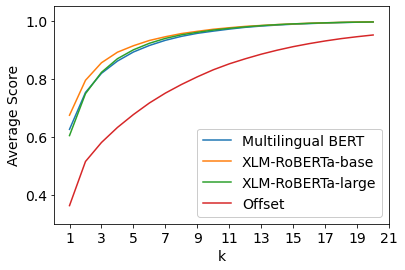

In [10]:
with open("data/depparse_german/dev.json", "r") as f:
    dataset = json.load(f)
relns = get_relns_NL(dataset)
print(relns)

with open("data/depparse_german/german_bert_topk_scores.pkl", "rb") as f:
    scores = pickle.load(f)
reln_avg = get_avg_NL(scores, relns, max_k=20)

with open("data/depparse_german/german_xlmr_base_topk_scores.pkl", "rb") as f:
    xlmr_base_scores = pickle.load(f)
xlmr_base_reln_avg = get_avg_NL(xlmr_base_scores, relns, max_k=20)

with open("data/depparse_german/german_xlmr_large_topk_scores.pkl", "rb") as f:
    xlmr_large_scores = pickle.load(f)
xlmr_large_reln_avg = get_avg_NL(xlmr_large_scores, relns, max_k=20)

with open("data/depparse_german/german_topk_scores_offset.pkl", "rb") as f:
    reln_scores_topk_offset = pickle.load(f)
scores_topk_offset = get_scores_topk(reln_scores_topk_offset, max_k=20)


print("bert", round(reln_avg[1]*100, 1), round(reln_avg[3]*100, 1), round(reln_avg[10]*100, 1), round(reln_avg[20]*100, 1))
print("xlmr_base", round(xlmr_base_reln_avg[1]*100, 1), round(xlmr_base_reln_avg[3]*100, 1), 
      round(xlmr_base_reln_avg[10]*100, 1), round(xlmr_base_reln_avg[20]*100, 1))
print("xlmr_large", round(xlmr_large_reln_avg[1]*100, 1), round(xlmr_large_reln_avg[3]*100, 1), 
      round(xlmr_large_reln_avg[10]*100, 1), round(xlmr_large_reln_avg[20]*100, 1))
print("offset", round(scores_topk_offset[1]*100, 1), round(scores_topk_offset[3]*100, 1), 
                                                   round(scores_topk_offset[10]*100, 1), round(scores_topk_offset[20]*100, 1))

plt.rcParams["figure.figsize"] = (8,5)
x = [k for k in range(1, 21)]
plt.plot(x, reln_avg[1:21], label = "Multilingual BERT")  # attention score
plt.plot(x, xlmr_base_reln_avg[1:21], label = "XLM-RoBERTa-base")  # attention score
plt.plot(x, xlmr_large_reln_avg[1:21], label = "XLM-RoBERTa-large")  # attention score
plt.plot(x, scores_topk_offset[1:21] ,  label = "Offset")

plt.xticks(range(1,22, 2))
plt.xlabel("k")
plt.ylabel("Average Score")
# plt.title("NL German")
plt.legend(framealpha=1, frameon=True, loc='lower right');
plt.ylim([0.3, 1.05])
fig = plt.gcf()
fig.set_size_inches(6., 4)
fig.savefig("../../data/figures/German.pdf", bbox_inches='tight')
plt.show()

# keywords only: 52 keywords
# offset only: 512 offsets
# keywords+offset: max of two


In [11]:
relns = [r for r,c in get_relns_by_frequency(dataset)]
relns.remove("root")
print_attn_baseline_table_NL(1, relns, [scores, xlmr_base_scores, xlmr_large_scores, reln_scores_topk_offset], 
["Multi BERT", "XLMR base", "XLMR large","offset"])

relation	Multi BERT	XLMR base	XLMR large	offset
det       	0.936 (5-8)	0.924 (5-1)	0.802 (10-15)	0.728 (1)
punct     	0.227 (8-6)	0.242 (8-10)	0.191 (1-9)	0.188 (-1)
case      	0.82  (5-8)	0.805 (3-9)	0.704 (10-15)	0.461 (1)
advmod    	0.476 (6-8)	0.496 (5-1)	0.44  (18-14)	0.351 (1)
obl       	0.333 (3-4)	0.366 (8-2)	0.243 (1-7)	0.241 (1)
nsubj     	0.379 (3-4)	0.564 (8-4)	0.458 (16-1)	0.182 (1)
nmod      	0.494 (2-5)	0.534 (8-2)	0.431 (1-3)	0.508 (-2)
amod      	0.882 (2-11)	0.952 (7-7)	0.933 (1-7)	0.933 (1)
obj       	0.523 (7-3)	0.658 (6-6)	0.583 (19-13)	0.184 (1)
conj      	0.578 (8-5)	0.634 (5-4)	0.58  (17-6)	0.309 (-2)
aux       	0.833 (5-8)	0.8   (5-1)	0.809 (18-14)	0.212 (-1)
cc        	0.698 (6-3)	0.742 (5-1)	0.669 (18-14)	0.515 (1)
flat:name 	0.785 (2-7)	0.829 (6-9)	0.785 (1-9)	0.785 (-1)
nummod    	0.965 (5-8)	0.954 (7-7)	0.949 (1-7)	0.949 (1)
mark      	0.637 (5-8)	0.56  (5-1)	0.541 (11-10)	0.342 (1)
appos     	0.499 (5-4)	0.553 (6-9)	0.391 (18-6)	0.376 (-1)
flat      	0.75

# dataset Statistics

In [12]:
# offset distribution plot

with open("data/depparse_english/dev.json", "r") as f:
    dataset = json.load(f)
with open("data/depparse_german/dev.json", "r") as f:
    dataset_german = json.load(f)


reln_to_offset = [{}, {}]
for i, d in [(0, dataset), (1, dataset_german)]:
    relns = get_relns_NL(d)
    for reln in relns:
        reln_to_offset[i][reln] = []
    reln_to_offset[i]["avg"] = []
    for example in d:
        for idx, (head, reln) in enumerate(zip(example["heads"], example["relns"])):
            if reln != "root":
                reln_to_offset[i][reln].append(head-(idx+1))
    for reln in relns:
        reln_to_offset[i]["avg"].append(sum(reln_to_offset[i][reln])/len(reln_to_offset[i][reln]))
#         reln_to_offset[i]["avg"].append((reln,sum(reln_to_offset[i][reln])/len(reln_to_offset[i][reln])))
#     reln_to_offset[i]["avg"].sort(key=lambda x:x[1])
#     print(reln_to_offset[i]["avg"])

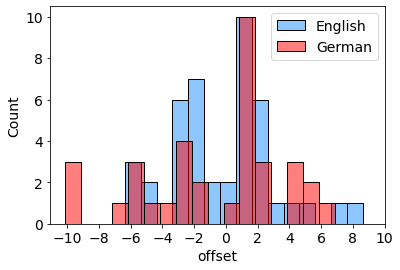

In [13]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(reln_to_offset[0]["avg"], binwidth=1, color="dodgerblue", label="English", alpha=0.5)
sns.histplot(reln_to_offset[1]["avg"], binwidth=1, color="red", label="German", alpha=0.5)
plt.xlabel("offset")
plt.legend()
fig.set_size_inches(6., 4)
plt.xticks(list(range(-10, 12, 2)))
fig.savefig("../../data/figures/offset_distribution_NL.pdf", bbox_inches='tight')
plt.show()

In [14]:
# dataset statistics
sentences = len(dataset) - [len(d['words']) for d in dataset].count(0)
print("English sentences", sentences)
print("relation types", len(get_relns_NL(dataset)))
print("relation edges", sum([len(d['relns']) for d in dataset]) - sentences)

English sentences 48883
relation types 43
relation edges 1147526


In [15]:
# dataset statistics
sentences = len(dataset_german) - [len(d['words']) for d in dataset_german].count(0)
print("_german sentences", sentences)
print("relation types", len(get_relns_NL(dataset_german)))
print("relation edges", sum([len(d['relns']) for d in dataset_german]) - sentences)

_german sentences 18459
relation types 35
relation edges 307791


In [16]:
dataset[315]

{'words': ['There', 'were', 'many', 'pioneer', 'PC', 'contributors', '.'],
 'relns': ['expl', 'root', 'amod', 'nn', 'nn', 'nsubj', 'punct'],
 'heads': [2, 0, 6, 6, 6, 2, 2]}